# 235 Final Project
### Team A1: Eileen Zhu, Kexin Zhou, Zijie Fang, Hongshan Lin

## Code Development

### 1. data import and preprocessing
(2 PTS)preprocessing include such tasks as imputing, binning, filtering, outlier treatment, feature engineering, text processing

In [2]:
##set up spark session
import os
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.sql.types import *       # for datatype conversion
from pyspark.sql.functions import *   # for col() function
import pandas as pd

sc = SparkContext.getOrCreate()

import pyspark.sql.types as typ
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("xor") \
    .config("spark.executor.memory", '2g') \
    .config('spark.executor.cores', '2') \
    .config('spark.cores.max', '2') \
    .config("spark.driver.memory",'4g') \
    .getOrCreate()

sc = spark.sparkContext
sqlCtx = SQLContext(sc)

#### Read in Data

In [3]:
## load in data as pyspark dataframe
path_to_data=os.path.join('/home/jovyan/235FinalProject/sampleddata.csv')
df=spark.read.csv(path_to_data,header=True)

In [4]:
df.show(3)

+---------+------+--------------------+
|BrandName|Rating|             Reviews|
+---------+------+--------------------+
|  Alcatel|     1|"Phone looks good...|
|    CNPGD|     5|           excelente|
|       LG|     5|The only way you ...|
+---------+------+--------------------+
only showing top 3 rows



In [5]:
#schema of df
df.printSchema()

root
 |-- BrandName: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)



In [6]:
# check missing values
df.describe().show()
#No missing values in Price and Rating, missing values in BrandName and Reviews

+-------+--------------------+------------------+--------------------+
|summary|           BrandName|            Rating|             Reviews|
+-------+--------------------+------------------+--------------------+
|  count|               84406|            100000|               99983|
|   mean|                null|           3.82029|             12345.0|
| stddev|                null|1.5487408762872643|                 NaN|
|    min|"BlackBerry Storm...|                 1|!!!!!Update!!!!! ...|
|    max|           worryfree|                 5|                  ü§ó|
+-------+--------------------+------------------+--------------------+



In [7]:
#drop missing values
data=df.na.drop()
data.count()

84391

In [8]:
data.describe().show() #no missing values, total 84391 rows

+-------+--------------------+------------------+--------------------+
|summary|           BrandName|            Rating|             Reviews|
+-------+--------------------+------------------+--------------------+
|  count|               84391|             84391|               84391|
|   mean|                null|3.8177649275396663|                null|
| stddev|                null|1.5459023383844865|                null|
|    min|"BlackBerry Storm...|                 1|!!!!!Update!!!!! ...|
|    max|           worryfree|                 5|                  ü§ó|
+-------+--------------------+------------------+--------------------+



#### Tokenizer

In [9]:
dataset=data.select(['Rating','Reviews'])

In [10]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

Tokenize reivews:

In [11]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
# regular expression tokenizer
#tokenizer = RegexTokenizer(inputCol="Reviews", outputCol="words", pattern="\\W")
tokenizer = Tokenizer(inputCol="Reviews", outputCol="words")
countTokens = udf(lambda words: len(words), IntegerType())

In [12]:
wordsData = tokenizer.transform(dataset)

In [13]:
wordsData.show(3)

+------+--------------------+--------------------+
|Rating|             Reviews|               words|
+------+--------------------+--------------------+
|     1|"Phone looks good...|["phone, looks, g...|
|     5|           excelente|         [excelente]|
|     5|The only way you ...|[the, only, way, ...|
+------+--------------------+--------------------+
only showing top 3 rows



Remove stop words such as a, the, etc.

In [14]:
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered")

In [15]:
filteredData=stopwordsRemover.transform(wordsData)

In [16]:
filteredData.show(3)

+------+--------------------+--------------------+--------------------+
|Rating|             Reviews|               words|            filtered|
+------+--------------------+--------------------+--------------------+
|     1|"Phone looks good...|["phone, looks, g...|["phone, looks, g...|
|     5|           excelente|         [excelente]|         [excelente]|
|     5|The only way you ...|[the, only, way, ...|[way, get, pure, ...|
+------+--------------------+--------------------+--------------------+
only showing top 3 rows



Translate words into features:

In [17]:
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=20)

In [18]:
featurizedData = hashingTF.transform(filteredData)

In [19]:
samplefeatures=featurizedData.select(['Rating','rawFeatures'])

In [20]:
idf = IDF(inputCol="rawFeatures", outputCol="features")

In [21]:
idfModel = idf.fit(samplefeatures)

In [22]:
rescaledData = idfModel.transform(samplefeatures)

In [23]:
rescaledData.show(3)

+------+--------------------+--------------------+
|Rating|         rawFeatures|            features|
+------+--------------------+--------------------+
|     1|(20,[0,1,2,3,4,5,...|(20,[0,1,2,3,4,5,...|
|     5|      (20,[7],[1.0])|(20,[7],[0.940086...|
|     5|(20,[1,4,11,19],[...|(20,[1,4,11,19],[...|
+------+--------------------+--------------------+
only showing top 3 rows



Translate Ratings into labels:

In [24]:
labelIndexer = StringIndexer(inputCol="Rating", outputCol="label")

In [25]:
model=labelIndexer.fit(rescaledData)

In [26]:
tf=model.transform(rescaledData)

In [27]:
tf.show(3)

+------+--------------------+--------------------+-----+
|Rating|         rawFeatures|            features|label|
+------+--------------------+--------------------+-----+
|     1|(20,[0,1,2,3,4,5,...|(20,[0,1,2,3,4,5,...|  1.0|
|     5|      (20,[7],[1.0])|(20,[7],[0.940086...|  0.0|
|     5|(20,[1,4,11,19],[...|(20,[1,4,11,19],[...|  0.0|
+------+--------------------+--------------------+-----+
only showing top 3 rows



Prepare dataset(as spark dataframe) for model building:

In [28]:
input_data=tf.select('label','features')

In [29]:
input_data.show(3)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  1.0|(20,[0,1,2,3,4,5,...|
|  0.0|(20,[7],[0.940086...|
|  0.0|(20,[1,4,11,19],[...|
+-----+--------------------+
only showing top 3 rows



### 2. data splitting/sampling
(1 PT)sampling may not be needed, but splitting is a must

In [30]:
(trainingData, testData) = input_data.randomSplit([0.7, 0.3],seed=88)

### 3. exploratory data analysis, with at least 2 graphs 
(2PTS)

#### Frequency Distribution for Reviews

In [30]:
#tranform df to pandas
filteredDataPanda=filteredData.select("filtered").toPandas()
#create a text file 
filteredDataPanda.to_csv('filtered_reviews.txt', index=False, sep=' ', header=None)

In [31]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [32]:
f = open('filtered_reviews.txt','r',encoding='utf-8').read()
from nltk.tokenize import word_tokenize 
  
word_tokens = word_tokenize(f) 
stop_words=list(nltk.corpus.stopwords.words('english')) 
# Add "phone" to the stop words dictionary
stop_words.append("phone")

filtered_sentence = [w for w in word_tokens if not w in stop_words] 

wl_space_split = " ".join(filtered_sentence)

#### Word Cloud for Reviews

In [35]:
from pyspark.sql import SparkSession

# In terminal, pip install wordcloud
from wordcloud import WordCloud

#ÂØºÂÖ•matplotlib‰ΩúÂõæÁöÑÂåÖ
import matplotlib.pyplot as plt

#ÁîüÊàê‰∏Ä‰∏™ËØç‰∫ëÂØπË±°
review_wc = WordCloud(
        background_color="white", #ËÆæÁΩÆËÉåÊôØ‰∏∫ÁôΩËâ≤ÔºåÈªòËÆ§‰∏∫ÈªëËâ≤
        width=1500,              #ËÆæÁΩÆÂõæÁâáÁöÑÂÆΩÂ∫¶
        height=960,              #ËÆæÁΩÆÂõæÁâáÁöÑÈ´òÂ∫¶
        margin=10               #ËÆæÁΩÆÂõæÁâáÁöÑËæπÁºò
        ).generate(wl_space_split)
# ÁªòÂà∂ÂõæÁâá
plt.imshow(review_wc)
# Ê∂àÈô§ÂùêÊ†áËΩ¥
plt.axis("off")
# Â±ïÁ§∫ÂõæÁâá
plt.show()
# ‰øùÂ≠òÂõæÁâá
review_wc.to_file('review_wc.png')

<Figure size 640x480 with 1 Axes>

#### Sentiment Words Analysis

In [115]:
#Word2Vec finding similar words
from pyspark.mllib.feature import Word2Vec

inp = filteredData.select("filtered")
word2vec = Word2Vec()
model = word2vec.fit(inp)

synonyms = model.findSynonyms('good', 10)

for word, cosine_distance in synonyms:
    print("{}: {}".format(word, cosine_distance))

Py4JJavaError: An error occurred while calling o2409.trainWord2VecModel.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 218.0 failed 1 times, most recent failure: Lost task 0.0 in stage 218.0 (TID 5738, localhost, executor driver): net.razorvine.pickle.PickleException: expected zero arguments for construction of ClassDict (for pyspark.sql.types._create_row)
	at net.razorvine.pickle.objects.ClassDictConstructor.construct(ClassDictConstructor.java:23)
	at net.razorvine.pickle.Unpickler.load_reduce(Unpickler.java:707)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:175)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:99)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:112)
	at org.apache.spark.mllib.api.python.SerDeBase$$anonfun$pythonToJava$1$$anonfun$apply$2.apply(PythonMLLibAPI.scala:1350)
	at org.apache.spark.mllib.api.python.SerDeBase$$anonfun$pythonToJava$1$$anonfun$apply$2.apply(PythonMLLibAPI.scala:1349)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:435)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:441)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:220)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsBytes(MemoryStore.scala:348)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1182)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.mllib.feature.Word2Vec.learnVocab(Word2Vec.scala:196)
	at org.apache.spark.mllib.feature.Word2Vec.fit(Word2Vec.scala:309)
	at org.apache.spark.mllib.feature.Word2Vec.fit(Word2Vec.scala:469)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.trainWord2VecModel(PythonMLLibAPI.scala:704)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: net.razorvine.pickle.PickleException: expected zero arguments for construction of ClassDict (for pyspark.sql.types._create_row)
	at net.razorvine.pickle.objects.ClassDictConstructor.construct(ClassDictConstructor.java:23)
	at net.razorvine.pickle.Unpickler.load_reduce(Unpickler.java:707)
	at net.razorvine.pickle.Unpickler.dispatch(Unpickler.java:175)
	at net.razorvine.pickle.Unpickler.load(Unpickler.java:99)
	at net.razorvine.pickle.Unpickler.loads(Unpickler.java:112)
	at org.apache.spark.mllib.api.python.SerDeBase$$anonfun$pythonToJava$1$$anonfun$apply$2.apply(PythonMLLibAPI.scala:1350)
	at org.apache.spark.mllib.api.python.SerDeBase$$anonfun$pythonToJava$1$$anonfun$apply$2.apply(PythonMLLibAPI.scala:1349)
	at scala.collection.Iterator$$anon$12.nextCur(Iterator.scala:435)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:441)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:220)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsBytes(MemoryStore.scala:348)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1182)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [36]:
import pyspark.sql.functions as F

In [37]:
gooddict = ["good","great","nice","wonderful","best","excellect","perfect","fantastic","greatest","love","like","awesome"]
baddict = ["bad","worse","worst","terrible","never","fake","not"]

In [41]:
datardd = filteredData.select("filtered").toJSON()
datardd

MapPartitionsRDD[72] at toJavaRDD at NativeMethodAccessorImpl.java:0

In [42]:
gooddata = datardd.filter(lambda r: "good" in r)
gooddata.take(2)

['{"filtered":["\\"phone","looks","good,","sounds","good,","even","good","hold","hand","tremendous","amount","lag,","takes","much","time","apps","install,","importantly,","signal","reception","device","terrible!!!","constantly","without","service","device.","soon","pop","sim","insert","g2","note","4,","boom,","full","4g","lte","(i\'m","at&t).","double","tap","wake","almost","never","works.","unorthodox","button","placement","pia","get","used","to.i","understand","lag","issue,","budge","device","come","alcatel.","2015,","phones","reception","problems","days","(there\'s","reason","see","\\"\\"can","hear","now\\"\\"","commercials...)\\""]}',
 '{"filtered":["good","chance","like","know","making","change","phone","cdma","work","country,","wonder","send","phone","gsm","technology","procedure","return"]}']

In [43]:
print("Positive Words Frenquecy in Reviews")
for g in gooddict:
    gooddata = datardd.filter(lambda r: g in r).count()
    print(g+": " +  str(gooddata))

Positive Words Frenquecy in Reviews
good: 16637
great: 17050
nice: 5272
wonderful: 695
best: 3397
excellect: 0
perfect: 5506
fantastic: 599
greatest: 100
love: 10574
like: 10216
awesome: 2242


In [44]:
print("Negative Words Frenquecy in Reviews")
for b in baddict:
    baddata = datardd.filter(lambda r: b in r).count()
    print(b+": " +  str(baddata))

Negative Words Frenquecy in Reviews
bad: 2608
worse: 315
worst: 633
terrible: 636
never: 2717
fake: 263
not: 6708


#### Brand Rating Analysis

In [45]:
#distinct brand count
#total 315 brands
print('rows={}'.format(data.select('BrandName').distinct().count()))

rows=315


In [46]:
#distribution of Brand reviews
brandcount=data.groupBy("BrandName").count() \
        .orderBy(col("count").desc())
brandcount.show(5)

+----------+-----+
| BrandName|count|
+----------+-----+
|   Samsung|16002|
|       BLU|15250|
|     Apple|14324|
|        LG| 5424|
|BlackBerry| 4028|
+----------+-----+
only showing top 5 rows



In [47]:
#comput average rating for each brand 
avgRating=data.groupBy("BrandName").agg(F.mean('Rating'))
avgRating.sort("avg(Rating)",ascending=False,inplace=True).show(5)

+--------------------+-----------+
|           BrandName|avg(Rating)|
+--------------------+-----------+
|samsung galaxy in...|        5.0|
|           Quick-get|        5.0|
|Seawolf Technologies|        5.0|
|           microsoft|        5.0|
|             Getnord|        5.0|
+--------------------+-----------+
only showing top 5 rows



In [48]:
#rate count for each brand
br=data.select(['BrandName','Rating'])
ratecount=br.groupBy("BrandName").count()\
            .orderBy(col("count").desc())\
            .selectExpr("BrandName as BrandName","count as ratecount")
ratecount.show(5)

+----------+---------+
| BrandName|ratecount|
+----------+---------+
|   Samsung|    16002|
|       BLU|    15250|
|     Apple|    14324|
|        LG|     5424|
|BlackBerry|     4028|
+----------+---------+
only showing top 5 rows



#### 5-Star Rate for Each Brand

In [49]:
# 5-star rate count for each brand
rate5starcount=br.filter(df["Rating"]==5)\
                .groupBy("BrandName").count()\
                .orderBy(col("count").desc())\
                .selectExpr("BrandName as BrandName","count as 5starratecount")
rate5starcount.show(5)

+----------+--------------+
| BrandName|5starratecount|
+----------+--------------+
|   Samsung|          9385|
|     Apple|          8783|
|       BLU|          7597|
|        LG|          2948|
|BlackBerry|          2141|
+----------+--------------+
only showing top 5 rows



In [50]:
#join all dataframes
data2=brandcount.join(avgRating,["BrandName"]).join(ratecount,["BrandName"]).join(rate5starcount,["BrandName"])

In [51]:
#compute 5-star rate count for each brand name
data3=data2.withColumn('5StarPercent',F.col('5starratecount')/F.col('ratecount')).sort("count",ascending=False,inplace=True)
data3.show(5)

+----------+-----+------------------+---------+--------------+------------------+
| BrandName|count|       avg(Rating)|ratecount|5starratecount|      5StarPercent|
+----------+-----+------------------+---------+--------------+------------------+
|   Samsung|16002| 3.973065866766654|    16002|          9385|0.5864891888513936|
|       BLU|15250| 3.787213114754098|    15250|          7597|0.4981639344262295|
|     Apple|14324|3.9247416922647305|    14324|          8783|0.6131667132086009|
|        LG| 5424| 3.840523598820059|     5424|          2948|0.5435103244837758|
|BlackBerry| 4028| 3.743296921549156|     4028|          2141|0.5315292949354519|
+----------+-----+------------------+---------+--------------+------------------+
only showing top 5 rows



#### Word Cloud for Brands Based on 5-Star Rate

In [52]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [53]:
# Select only "BrandName" and its frequencies
five_star_rate=data3.select("BrandName","5StarPercent").sort("5StarPercent",ascending=False,inplace=True)
# Transform df to list
frequencies = five_star_rate.toPandas().set_index('BrandName').T.to_dict('records')

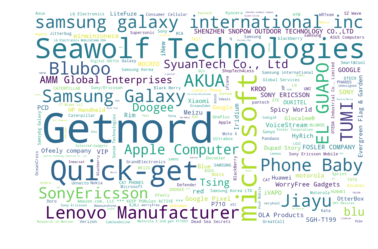

In [54]:
five_star_rate_wc = WordCloud(
        background_color="white", #ËÆæÁΩÆËÉåÊôØ‰∏∫ÁôΩËâ≤ÔºåÈªòËÆ§‰∏∫ÈªëËâ≤
        width=1500,              #ËÆæÁΩÆÂõæÁâáÁöÑÂÆΩÂ∫¶
        height=960,              #ËÆæÁΩÆÂõæÁâáÁöÑÈ´òÂ∫¶
        margin=10               #ËÆæÁΩÆÂõæÁâáÁöÑËæπÁºò
        ).generate_from_frequencies(dict(*frequencies))
plt.figure()
plt.imshow(five_star_rate_wc, interpolation="bilinear")
plt.axis("off")
plt.show()
# Save Image
five_star_rate_wc.to_file('five_star_rate_wc.png') 

#### Brand Distribution & Average Rating

In [55]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [56]:
top20=data3.collect()[0:20]
Brands = [i[0] for i in top20]
counts = [i[1] for i in top20]
ratingavg=[i[2] for i in top20]
starpercentage=[i[5] for i in top20]
ind = np.array(range(len(top20)))
width = 0.35

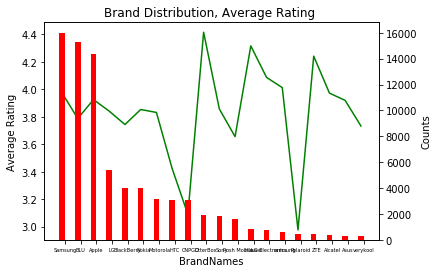

In [57]:
fig, ax1 = plt.subplots()
#plot first graph
plt.plot(ind, ratingavg, color='g')
plt.xticks(ind + width/2., Brands,fontsize=5)
plt.xlabel('BrandNames')
plt.ylabel('Average Rating')
plt.title('Brand Distribution, Average Rating ')

ax2 = ax1.twinx()
#plot second graph
plt.bar(ind, counts, width=width, color='r')
plt.ylabel('Counts')
plt.xlabel('Brand Names')
plt.xticks(ind + width/2., Brands,fontsize=5)

plt.show()

#### Word Cloud for Samsung

In [58]:
reviewSamsung=data.filter(data["BrandName"]=="Samsung")

In [59]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="Reviews", outputCol="words", pattern="\\W")
# stop words
stop_words=list(nltk.corpus.stopwords.words('english')) 

In [60]:
# Add "phone" to the stop words dictionary
stop_words.append("phone")

In [61]:
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered",stopWords=stop_words)

In [62]:
#tokenize Samsung reivews
pipelinerate=Pipeline(stages=[regexTokenizer,stopwordsRemover])
pipelineratefit=pipelinerate.fit(reviewSamsung)
datasetReview=pipelineratefit.transform(reviewSamsung)
datasetReview.show(5)

+---------+------+--------------------+--------------------+--------------------+
|BrandName|Rating|             Reviews|               words|            filtered|
+---------+------+--------------------+--------------------+--------------------+
|  Samsung|     5|I bought this as ...|[i, bought, this,...|[bought, travel, ...|
|  Samsung|     4|This is a great p...|[this, is, a, gre...|[great, easy, set...|
|  Samsung|     5|Great phone with ...|[great, phone, wi...|[great, fantastic...|
|  Samsung|     5|       Great Product|    [great, product]|    [great, product]|
|  Samsung|     5|i bought this as ...|[i, bought, this,...|[bought, gift, so...|
+---------+------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [63]:
datasetPanda=datasetReview.select("filtered").toPandas()
#create a text file 
datasetPanda.to_csv('Samsung.txt', index=False, sep=' ', header=None)

In [64]:
f = open('Samsung.txt','r',encoding='utf-8').read()
from nltk.tokenize import word_tokenize 
  
word_tokens = word_tokenize(f) 
  
filtered_sentence = [w for w in word_tokens if not w in stop_words] 

wl_space_split = " ".join(filtered_sentence)

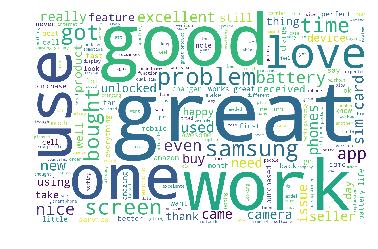

In [65]:
from pyspark.sql import SparkSession

# In terminal, pip install wordcloud
from wordcloud import WordCloud

#ÂØºÂÖ•matplotlib‰ΩúÂõæÁöÑÂåÖ
import matplotlib.pyplot as plt

#ÁîüÊàê‰∏Ä‰∏™ËØç‰∫ëÂØπË±°
wordcloud = WordCloud(
        background_color="white", #ËÆæÁΩÆËÉåÊôØ‰∏∫ÁôΩËâ≤ÔºåÈªòËÆ§‰∏∫ÈªëËâ≤
        width=1500,              #ËÆæÁΩÆÂõæÁâáÁöÑÂÆΩÂ∫¶
        height=960,              #ËÆæÁΩÆÂõæÁâáÁöÑÈ´òÂ∫¶
        margin=10               #ËÆæÁΩÆÂõæÁâáÁöÑËæπÁºò
        ).generate(wl_space_split)
# ÁªòÂà∂ÂõæÁâá
plt.imshow(wordcloud)
# Ê∂àÈô§ÂùêÊ†áËΩ¥
plt.axis("off")
# Â±ïÁ§∫ÂõæÁâá
plt.show()
# ‰øùÂ≠òÂõæÁâá
wordcloud.to_file('Samsung_wc.png')

### 4. model construction, with at least 3 models
(3PTS) ideally the models are constructed using pipelines

A complete project will consider at least 2 models:

1.  A benchmark model, which is relatively simple.  This could be a regression model with a small number of features (possibly a single feature).  This provides a basis for comparison and a sanity check.
2. A more sophisticated model, which could be one of the models covered in class.  The best model found in your experiments is called the champion model.

The model construction process should follow the best practices covered in class, including:

a.	Data preprocessing.  The required steps will depend on the model, and could include:

	i. dummy variable construction
	ii. feature scaling
 	iii. handling missing values and outliers
	iv. handling semi-structured / unstructured data
	v. dimensionality reduction (e.g., PCA)

b.	Data splitting (train/validation/test sets, for example).  The test set should be left out for evaluation purposes.  It should NOT be used in training.
c.	K-fold cross validation of hyperparameters


#### Lasso Regression

In [32]:
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.regression import LabeledPoint

In [33]:
#data 
#input_data--> 0.7trainingData, 0.3 testData


Lasso not binary

In [34]:
lr= LinearRegression(featuresCol="features",labelCol="label",maxIter=10, regParam=0.3, elasticNetParam=1)
model = lr.fit(trainingData)

In [35]:
#evaluate
pred_test=model.transform(testData)
pred2=pred_test.rdd.map(lambda r:(r.label,r.prediction))
MSE=pred2.map(lambda r:(r[0]-r[1])*(r[0]-r[1]))\
.reduce(lambda x,y:x+y)/pred2.count()
MSE

1.5149209648635287

In [153]:
pred_test.groupBy("prediction")\
.count()\
.show()

+------------------+-----+
|        prediction|count|
+------------------+-----+
|0.9509320545724707|25167|
+------------------+-----+



In [41]:
# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(pred_test)
print("Test set accuracy = " + str(accuracy))

Test set accuracy = 0.0


Lasso Binary

In [47]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [43]:
#data
input_data=tf.select('Rating','features')
input_data_b = input_data.withColumn("Rating",F.when(input_data["Rating"] >=4, 1).otherwise(0))
(trainingData_b, testData_b) = input_data_b.randomSplit([0.7, 0.3],seed=88)


In [44]:
lr= LinearRegression(featuresCol="features",labelCol="Rating",maxIter=10, regParam=0.3, elasticNetParam=1)
model = lr.fit(trainingData_b)

In [45]:
#evaluate
pred_test=model.transform(testData_b)
pred2=pred_test.rdd.map(lambda r:(r.Rating,r.prediction))
MSE=pred2.map(lambda r:(r[0]-r[1])*(r[0]-r[1]))\
.reduce(lambda x,y:x+y)/pred2.count()
MSE

0.21345881666309932

In [162]:
pred2_rdd = spark.sparkContext.parallelize(pred2.collect())

In [166]:
# compute accuracy on the test set
lassometrics = BinaryClassificationMetrics(pred2_rdd)
lassometrics.areaUnderROC

1.0

#### Logistic Regression

In [1]:
import pandas as pd
import pyspark.sql.functions as F
import pyspark.mllib.regression as reg
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [102]:
# parameters
training_fraction = 0.6
ITERS = 10
target = 'label'
good_rating = 4
bad_rating = 3
SEED = 314
vars_to_keep=["features"]

In [ ]:
#data: traingData_rdd, testData_b
#perform logistic regression
LR_Model = LogisticRegressionWithLBFGS.train(trainingData_rdd, iterations=ITERS,intercept=True)
act_pred_test_set1 = testData_b.rdd.map(lambda p: ([p.Rating, LR_Model.predict(p.features)]))\
.map(lambda row: (row[0], row[1] * 1.0))
MSE=act_pred_test_set1.map(lambda r:(r[0]-r[1])*(r[0]-r[1]))\
.reduce(lambda x,y:x+y)/act_pred_test_set1.count()
MSE

#### SVM


In [186]:
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint

training_bpandas=trainingData_b.toPandas()
training_bpandas.to_csv('trainingb.txt', index=False, sep=' ', header=None)
# Load and parse the data
def parsePoint(line):
    values = [float(x) for x in line.split(' ')]
    return LabeledPoint(values[0], values[1:])

data = sc.textFile("trainingb.txt")
parsedData = data.map(parsePoint)

# Build the model
model = SVMWithSGD.train(parsedData, iterations=100)

# Evaluating the model on training data
labelsAndPreds = parsedData.map(lambda p: (p.label, model.predict(p.features)))
trainErr = labelsAndPreds.filter(lambda lp: lp[0] != lp[1]).count() / float(parsedData.count())
print("Training Error = " + str(trainErr))



Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 515.0 failed 1 times, most recent failure: Lost task 0.0 in stage 515.0 (TID 1402, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-186-b4ca83dead11>", line 8, in parsePoint
  File "<ipython-input-186-b4ca83dead11>", line 8, in <listcomp>
ValueError: could not convert string to float: '(20,[],[])'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor96.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/pyspark/rdd.py", line 1354, in takeUpToNumLeft
    yield next(iterator)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-186-b4ca83dead11>", line 8, in parsePoint
  File "<ipython-input-186-b4ca83dead11>", line 8, in <listcomp>
ValueError: could not convert string to float: '(20,[],[])'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.api.python.PythonRDD$$anonfun$3.apply(PythonRDD.scala:153)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [167]:
from pyspark.mllib.classification import SVMWithSGD

In [179]:
#data-input_data_b(binary)
trainingData_rdd = trainingData_b.rdd.map(lambda row:reg.LabeledPoint(row[0],row[1:]))
testData_rdd=testData_b.rdd.map(lambda row: reg.LabledPoint(row[0],row[1:]))

In [169]:
model = SVMWithSGD.train(trainingData_rdd)

In [170]:
testData_b.printSchema()

root
 |-- Rating: integer (nullable = false)
 |-- features: vector (nullable = true)



In [132]:
#schema=StructType([StructField('Rating',FloatType()),StructField('prediction',FloatType())])
#predset_df=sqlCtx.createDataFrame(predset,schema)

In [171]:
#tempFile=NameTemporaryFile(delete=True)
#tempFile.close()
#predset.saveAsTextFile(tempFile.name)

In [180]:
#evaluate
predset = testData_rdd.map(lambda p: (p.Rating,model.predict(p.features)))\
.map(lambda p: (p[0],p[1]*1.0))
#MSE=predset.map(lambda r:(r[0]-r[1])*(r[0]-r[1]))\
#.reduce(lambda x,y:x+y)/predset.count()
#MSE
#predset_rdd = spark.sparkContext.parallelize(predset.collect())

In [184]:
labelsAndPreds = trainingData_rdd.map(lambda p: (p.Rating, model.predict(p.features)))
trainErr = labelsAndPreds.filter(lambda lp: lp[0] != lp[1]).count() / float(testData_b.count())
print("Training Error = " + str(trainErr))

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 511.0 failed 1 times, most recent failure: Lost task 1.0 in stage 511.0 (TID 1396, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 352, in func
    return f(iterator)
  File "/usr/local/spark/python/pyspark/rdd.py", line 1055, in <lambda>
    return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
  File "/usr/local/spark/python/pyspark/rdd.py", line 1055, in <genexpr>
    return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-184-d3bfde0a8f37>", line 1, in <lambda>
AttributeError: 'LabeledPoint' object has no attribute 'Rating'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:945)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor123.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 2499, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/local/spark/python/pyspark/rdd.py", line 352, in func
    return f(iterator)
  File "/usr/local/spark/python/pyspark/rdd.py", line 1055, in <lambda>
    return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
  File "/usr/local/spark/python/pyspark/rdd.py", line 1055, in <genexpr>
    return self.mapPartitions(lambda i: [sum(1 for _ in i)]).sum()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-184-d3bfde0a8f37>", line 1, in <lambda>
AttributeError: 'LabeledPoint' object has no attribute 'Rating'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1$$anonfun$13.apply(RDD.scala:945)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [68]:
#metrics.areaUnderROC
print("Area under ROC = %s" % metrics.areaUnderROC)
# Area under precision-recall curve
#print("Area under PR = %s" % metrics.areaUnderPR)
# Area under ROC curve
#print("Area under ROC = %s" % metrics.areaUnderROC)

Py4JJavaError: An error occurred while calling o928.areaUnderROC.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 152.0 failed 1 times, most recent failure: Lost task 1.0 in stage 152.0 (TID 285, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-65-5cc36a6fa28a>", line 2, in <lambda>
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/mllib/classification.py", line 470, in predict
    x = _convert_to_vector(x)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'pyspark.ml.linalg.SparseVector'> into Vector

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:191)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:62)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.RangePartitioner$.sketch(Partitioner.scala:309)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:171)
	at org.apache.spark.RangePartitioner.<init>(Partitioner.scala:151)
	at org.apache.spark.rdd.OrderedRDDFunctions$$anonfun$sortByKey$1.apply(OrderedRDDFunctions.scala:62)
	at org.apache.spark.rdd.OrderedRDDFunctions$$anonfun$sortByKey$1.apply(OrderedRDDFunctions.scala:61)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.OrderedRDDFunctions.sortByKey(OrderedRDDFunctions.scala:61)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.x$4$lzycompute(BinaryClassificationMetrics.scala:155)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.x$4(BinaryClassificationMetrics.scala:146)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.confusions$lzycompute(BinaryClassificationMetrics.scala:148)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.confusions(BinaryClassificationMetrics.scala:148)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.createCurve(BinaryClassificationMetrics.scala:223)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.roc(BinaryClassificationMetrics.scala:86)
	at org.apache.spark.mllib.evaluation.BinaryClassificationMetrics.areaUnderROC(BinaryClassificationMetrics.scala:97)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-65-5cc36a6fa28a>", line 2, in <lambda>
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/mllib/classification.py", line 470, in predict
    x = _convert_to_vector(x)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'pyspark.ml.linalg.SparseVector'> into Vector

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:191)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:62)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


#### Random Forest

In [73]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [74]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(input_data)

In [75]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 5 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=5).fit(input_data)

In [76]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

In [77]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [78]:
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

In [79]:
# Train model.  This also runs the indexers.
trainedmodel = pipeline.fit(trainingData)

In [80]:
# Make predictions.
rfpredictions = trainedmodel.transform(testData)

In [81]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

In [83]:
accuracy = evaluator.evaluate(rfpredictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.457226


In [84]:
# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

# Fit the classifier to the training data
nb_classifier.fit(tfidf_train,y_train)

# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print('Accuracy is:',score)
f1 = metrics.f1_score(y_test, pred)
print('F score is:',f1)

NameError: name 'MultinomialNB' is not defined

#### Decision Tree

In [85]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load the data stored in LIBSVM format as a DataFrame.


# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(input_data)
# Automatically identify categorical features, and index them.
# We specify maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(input_data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = input_data.randomSplit([0.7, 0.3])

# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))

treeModel = model.stages[2]
# summary only
print(treeModel)

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       0.0|         0.0|          (20,[],[])|
|       0.0|         0.0|(20,[0],[0.618925...|
|       0.0|         0.0|(20,[0],[0.618925...|
|       0.0|         0.0|(20,[0],[0.618925...|
|       0.0|         0.0|(20,[0],[0.618925...|
+----------+------------+--------------------+
only showing top 5 rows

Test Error = 0.448112 
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_0aa4ec186305) of depth 5 with 21 nodes


In [119]:
#Áîª‰∏çÂá∫Ê†ëÊù•QAQÊÄé‰πàÂäûÔºÅ
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree
from pyspark.mllib.util import MLUtils
data = MLUtils.loadLibSVMFile(sc,'/home/jovyan/235FinalProject/sampleddata.csv').cache()
# Load and parse the data file into an RDD of LabeledPoint.
# Cache the data since we will use it again to compute training error.

# Train a DecisionTree model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
model = DecisionTree.trainClassifier(input_data, numClasses=2, categoricalFeaturesInfo={},
                                     impurity='gini', maxDepth=5, maxBins=100)

# Evaluate model on training instances and compute training error
predictions = model.predict(input_data.map(lambda x: x.features))
labelsAndPredictions = input_data.map((lambda lp: lp.label).zip(predictions))
trainErr = labelsAndPredictions.filter(lambda seq: seq[0] != seq[1]).count() / float(input_data.count())
print('Training Error = ' + str(trainErr))
print('Learned classification tree model:')
print(model)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 221.0 failed 1 times, most recent failure: Lost task 0.0 in stage 221.0 (TID 5741, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/usr/local/spark/python/pyspark/mllib/util.py", line 123, in <lambda>
    parsed = lines.map(lambda l: MLUtils._parse_libsvm_line(l))
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/mllib/util.py", line 48, in _parse_libsvm_line
    label = float(items[0])
ValueError: could not convert string to float: 'BrandName,Rating,Reviews'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:220)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsBytes(MemoryStore.scala:348)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1182)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1887)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1875)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1874)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1874)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2108)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2057)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2046)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:945)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:944)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 367, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 390, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/usr/local/spark/python/pyspark/mllib/util.py", line 123, in <lambda>
    parsed = lines.map(lambda l: MLUtils._parse_libsvm_line(l))
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/mllib/util.py", line 48, in _parse_libsvm_line
    label = float(items[0])
ValueError: could not convert string to float: 'BrandName,Rating,Reviews'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:452)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:588)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:571)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:406)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:220)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsBytes(MemoryStore.scala:348)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1182)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:335)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:286)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:121)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:402)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:408)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


#### Naive Bayes ÔºàÊòØ‰∏çÊòØË¶ÅÁî®pipelineÔºüÔºüÔºüÔºâ

In [87]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load training data


# Split the data into train and test
splits = input_data.randomSplit([0.7, 0.3], 1234)
train = splits[0]
test = splits[1]

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

# train the model
model = nb.fit(train)

# select example rows to display.
predictions = model.transform(test)
predictions.show()

# compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|          (20,[],[])|[-0.6243668042417...|[0.53560046111073...|       0.0|
|  0.0|          (20,[],[])|[-0.6243668042417...|[0.53560046111073...|       0.0|
|  0.0|          (20,[],[])|[-0.6243668042417...|[0.53560046111073...|       0.0|
|  0.0|(20,[0],[0.618925...|[-2.4161454326223...|[0.59789112936373...|       0.0|
|  0.0|(20,[0],[0.618925...|[-2.4161454326223...|[0.59789112936373...|       0.0|
|  0.0|(20,[0],[0.618925...|[-2.4161454326223...|[0.59789112936373...|       0.0|
|  0.0|(20,[0],[0.618925...|[-2.4161454326223...|[0.59789112936373...|       0.0|
|  0.0|(20,[0],[0.618925...|[-2.4161454326223...|[0.59789112936373...|       0.0|
|  0.0|(20,[0],[0.618925...|[-2.4161454326223...|[0.59789112936373...|       0.0|
|  0.0|(20,[0],[

### 5. model evaluation 
(2PTS) this should include computation of relevant metrics, and a comparison between models

For all appropriate models (benchmark, champion, and other relevant models), the following should be conducted:

a. Evaluate relevant metrics

For regression, this would include 
i.  R-squared (for single factor)
ii. Adjusted R-squared (for multifactor)

For classification, this would include:

	i. accuracy
	ii. precision, recall, F1 score
	ii. confusion matrix
iv. area under ROC curve (AUROC)
 
Depending on the application, additional evaluation could make sense such as lift charts


b. Sensitivity analysis

Sensitivity analysis measures the effect of changing the model inputs or parameters.  For example, if the model uses a hyperparameter C, how does AUROC change when feature X is increased/decreased by one standard deviation.  The hope is that sensitivity is low.

